In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [2]:
parameter = {
    "z_size": 64,
    "img_size":784,
    "hidden_size": 32,
    "output_size":1,
    "lr": 0.0002,
    "n_epoch": 200,
    "batch_size": 100,
    "num_workers": 0
}
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.model = nn.Sequential(
        nn.Linear(parameter['img_size'],parameter['hidden_size']*4),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        nn.Linear(parameter['hidden_size']*4,parameter['hidden_size']*2),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        nn.Linear(parameter['hidden_size']*2,parameter['hidden_size']),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        nn.Linear(parameter['hidden_size'],1),
        nn.Sigmoid()
    )

  def forward(self,x):
    return self.model(x)

class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.model = nn. Sequential(
        nn.Linear(parameter['z_size'],parameter['hidden_size']),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        nn.Linear(parameter['hidden_size'], parameter['hidden_size']*2),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        nn.Linear(parameter['hidden_size']*2, parameter['hidden_size']*4),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        nn.Linear(parameter['hidden_size']*4,parameter['img_size']),
        nn.Tanh()
    )

  def forward(self,x):
    return self.model(x)

In [4]:
D = Discriminator().to(device)
G = Generator().to(device)

print(D)
print(G)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
    (10): Sigmoid()
  )
)
Generator(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Li

In [5]:
d_optimizer = optim.Adam(D.parameters(), lr = parameter['lr'])
g_optimizer = optim.Adam(G.parameters(), lr = parameter['lr'])

criterion = nn.BCELoss()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



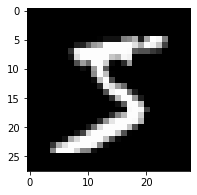

In [6]:
def prepare_data():
  return torchvision.datasets.MNIST(root = 'data', train = True,
                                    download = True, transform = transforms.Compose([transforms.ToTensor(),
                                                                                     transforms.Normalize(mean=[0.5],
                                                                                                          std=[0.5])]))

def prepare_loader(dataset):
  train_loader = torch.utils.data.DataLoader(dataset, batch_size=parameter['batch_size'],
                                             num_workers = parameter['num_workers'])
  return train_loader

dataset = prepare_data()
train_loader = prepare_loader(dataset)

dataIter = iter(train_loader)
images, labels = dataIter.next()

img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111) 
ax.imshow(img, cmap='gray')
 

In [8]:
G_losses = []
D_losses = []
total_step = len(train_loader)
fixed_z = torch.randn(parameter['batch_size'], parameter['z_size']).to(device)


for epoch in range(parameter['n_epoch']):
    for batch_i, (images, _) in enumerate(train_loader):
        images = images.view(parameter['batch_size'], -1).to(device)
        
        real_labels = torch.ones(parameter['batch_size'], 1).to(device)
        fake_labels = torch.zeros(parameter['batch_size'], 1).to(device)

        #TRAIN DISCRIMINATOR
        D_real = D(images)
        D_real_loss = criterion(D_real, real_labels)
    
        z = torch.randn(parameter['batch_size'], parameter['z_size']).to(device)
        D_fake = D(G(z))
        D_fake_loss = criterion(D_fake, fake_labels)
        
        D_loss = D_real_loss + D_fake_loss
        d_optimizer.zero_grad()
        D_loss.backward()
        d_optimizer.step()
        
        #TRAIN GENERATOR

        z = torch.randn(parameter['batch_size'], parameter['z_size']).to(device)
        G_fake = D(G(z))
        
        G_loss = criterion(G_fake, real_labels)
        
        g_optimizer.zero_grad()
        G_loss.backward()
        g_optimizer.step()
        
        if (batch_i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}' 
                  .format(epoch, 200, batch_i+1, total_step, D_loss.item(), G_loss.item()))
        
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
    
    fake_images = G(fixed_z).reshape(G(fixed_z).size(0), 1, 28, 28)
    imgs = torchvision.utils.make_grid(fake_images)
    npimgs = imgs.detach().cpu().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

        





Output hidden; open in https://colab.research.google.com to view.

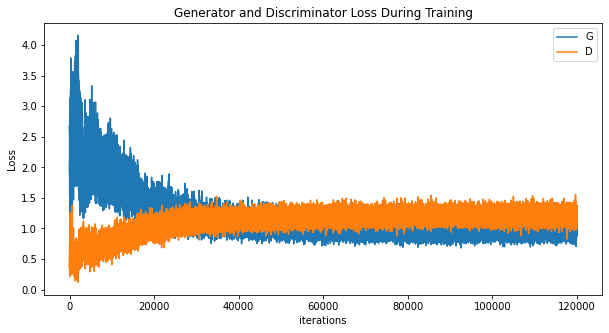

In [9]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



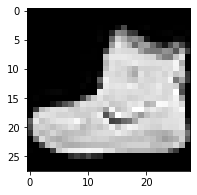

In [10]:
def prepare_data_FASHIONMNIST():
  return torchvision.datasets.FashionMNIST(root = 'data', train = True,
                                    download = True, transform = transforms.Compose([transforms.ToTensor(),
                                                                                     transforms.Normalize(mean=[0.5],
                                                                                                          std=[0.5])]))


dataset = prepare_data_FASHIONMNIST()
train_loader_fashion = prepare_loader(dataset)

dataIter = iter(train_loader_fashion)
images, labels = dataIter.next()

img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111) 
ax.imshow(img, cmap='gray')

In [13]:
criterion = nn.BCELoss()
total_step = len(train_loader)
G_losses = []
D_losses = []
total_step = len(train_loader)
fixed_z = torch.randn(parameter['batch_size'], parameter['z_size']).to(device)

for epoch in range(50):
    for batch_i, (images, _) in enumerate(train_loader_fashion):
        images = images.view(parameter['batch_size'], -1).to(device)
        
        real_labels = torch.ones(parameter['batch_size'], 1).to(device)
        fake_labels = torch.zeros(parameter['batch_size'], 1).to(device)

        #TRAIN DISCRIMINATOR
        D_real = D(images)
        D_real_loss = criterion(D_real, real_labels)
    
        z = torch.randn(parameter['batch_size'], parameter['z_size']).to(device)
        D_fake = D(G(z))
        D_fake_loss = criterion(D_fake, fake_labels)
        
        D_loss = D_real_loss + D_fake_loss
        d_optimizer.zero_grad()
        D_loss.backward()
        d_optimizer.step()
        
        #TRAIN GENERATOR

        z = torch.randn(parameter['batch_size'], parameter['z_size']).to(device)
        G_fake = D(G(z))
        
        G_loss = criterion(G_fake, real_labels)
        
        g_optimizer.zero_grad()
        G_loss.backward()
        g_optimizer.step()
        
        if (batch_i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}' 
                  .format(epoch, 50, batch_i+1, total_step, D_loss.item(), G_loss.item()))
        
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
    
    
    fake_images = G(fixed_z).reshape(G(fixed_z).size(0), 1, 28, 28)
    imgs = torchvision.utils.make_grid(fake_images)
    npimgs = imgs.detach().cpu().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

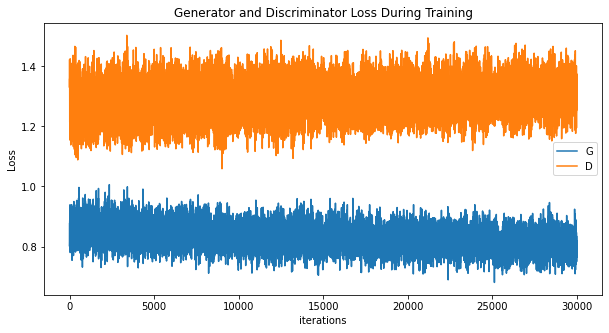

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()